<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_2_conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title IMPORTS
import numpy as np
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from IPython.display import clear_output

In [2]:
#@title INSPECTING DEVICE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#@title DOWNLOAD DATA
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.CIFAR10(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False,
                                  download=True, transform=transform)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
#@title HYPERPARAMETERS AND DATALOADERS
batch_size = 64
epochs = 100
learning_rate = 1e-3

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, shuffle=True)

In [5]:
#@title PREVIEW THE IMAGES
def imshow(img):    
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def plot_images(images, labels, no):  
  rows = int(math.sqrt(no))
  plt.ion()
  fig = plt.figure(figsize=(rows*2, rows*2))      
  for idx in np.arange(no):
      ax = fig.add_subplot(rows, no/rows, idx+1, xticks=[], yticks=[])
      imshow(images[idx])
      ax.set_title(classes[labels[idx]]) 
  time.sleep(0.1)
  plt.pause(0.0001)  

 # obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

plot_images(images,labels,25)   

In [7]:
#@title CONVOLUTIONAL AUTOENCODER
class ConvAutoencoder(nn.Module):
  def __init__(self):
    super(ConvAutoencoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 16, 3, padding=1), 
      nn.ReLU(True),
      nn.MaxPool2d(2, 2),
      nn.Conv2d(16, 4, 3, padding=1), 
      nn.ReLU(True),
      nn.MaxPool2d(2, 2)
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(4, 16, 2, stride=2),
      nn.ReLU(True),
      nn.ConvTranspose2d(16, 3, 2, stride=2),
      nn.Sigmoid()
    )

  def forward(self, x):        
    x = self.encoder(x)
    x = self.decoder(x)
    return x

model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


In [8]:
#@title LOSS AND OPTIMIZER
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch: 100 Training Loss: 0.421


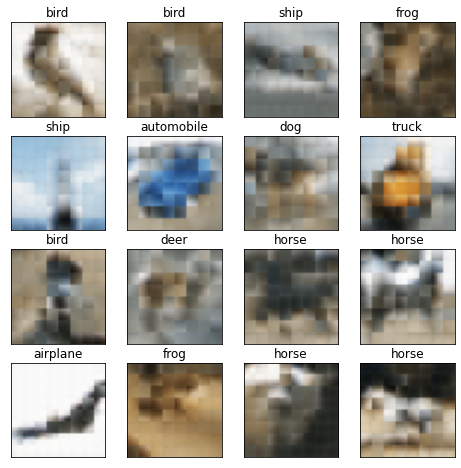

In [9]:
#@title TRAINING
for epoch in range(epochs):    
  train_loss = 0.0    
  for data in train_loader:        
    images, labels = data        
    optimizer.zero_grad()        
    generated = model(images)        
    loss = loss_fn(generated, images)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*images.size(0)
          
  train_loss = train_loss/len(train_loader)
  clear_output()
  print(f'Epoch: {epoch+1} Training Loss: {train_loss:.3f}')    
  plot_images(generated.detach(),labels,16)   
    